<a href="https://colab.research.google.com/github/TheRufael/CS770-Assignments/blob/main/Assignment_Three_Q2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Project Overview

# 0. Set seeds for reproducibility and created a fixed train–validation split.
# 1. Loaded Fashion MNIST, normalized images, and one-hot encoded labels.
# 2. Built two model families:
#      - Basic CNN (1–2 convolution blocks)
#      - Deep CNN (3–4 convolution blocks)
# 3. Tuned key hyperparameters for both model families.
# 4. Trained each configuration for 30 epochs and recorded accuracy and training time.
# 5. Collected model statistics such as parameter counts and memory estimates.
# 6. Plotted training and validation curves to study convergence and overfitting.
# 7. Generated confusion matrices to evaluate class-level performance.
# 8. Visualized learned filters from early and deeper convolution layers.
# 9. Compared both models and summarized results.


In [ ]:
# 0) Setup and reproducibility
SEED = 42 # Set a fixed seed for reproducibility

import os, time, random, math
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, utils # Import necessary Keras modules
import pandas as pd
from sklearn.model_selection import train_test_split # For splitting data
from sklearn.metrics import confusion_matrix # For confusion matrix
import matplotlib.pyplot as plt # For plotting
import seaborn as sns # For enhanced visualizations

# Seeds and determinism
random.seed(SEED)
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
tf.random.set_seed(SEED)
try:
    tf.config.experimental.enable_op_determinism(True) # Enable deterministic operations if available
except Exception:
    pass

# GPU memory growth
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    for g in gpus:
        try:
            tf.config.experimental.set_memory_growth(g, True) # Allow GPU memory growth
        except Exception:
            pass

print("TensorFlow:", tf.__version__)
print("NumPy:", np.__version__)
try:
    import sklearn
    print("Scikit-learn:", sklearn.__version__)
except Exception:
    pass
print("GPU devices:", tf.config.list_physical_devices("GPU")) # List available GPU devices
# 1) Data: load, normalize, one-hot, fixed split
# Load Fashion MNIST dataset
(x_train_full, y_train_full), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

# Normalize pixel values to [0, 1] and add channel dimension
x_train_full = (x_train_full.astype("float32") / 255.0)[..., None]
x_test       = (x_test.astype("float32")       / 255.0)[..., None]

NUM_CLASSES = 10 # Number of classes in Fashion MNIST
# Convert labels to one-hot encoding
y_train_full_oh = utils.to_categorical(y_train_full, NUM_CLASSES)
y_test_oh       = utils.to_categorical(y_test, NUM_CLASSES)

# Split training data into training and validation sets (80/20)
x_train, x_val, y_train, y_val = train_test_split(
    x_train_full, y_train_full_oh,
    test_size=0.20, random_state=SEED, stratify=y_train_full # Stratify to maintain class distribution
)

INPUT_SHAPE = (28, 28, 1) # Input image shape
BATCH_SIZE  = 64 # Batch size for training
EPOCHS      = 30 # Number of training epochs

# Create tf.data input pipelines for efficient data loading
AUTOTUNE = tf.data.AUTOTUNE # Automatically tune prefetch buffer size
train_ds = (tf.data.Dataset.from_tensor_slices((x_train, y_train))
            .shuffle(60000, seed=SEED, reshuffle_each_iteration=True) # Shuffle training data
            .batch(BATCH_SIZE).cache().prefetch(AUTOTUNE)) # Batch, cache, and prefetch
val_ds   = (tf.data.Dataset.from_tensor_slices((x_val, y_val))
            .batch(BATCH_SIZE).cache().prefetch(AUTOTUNE)) # Batch, cache, and prefetch validation data
test_ds  = (tf.data.Dataset.from_tensor_slices((x_test, y_test_oh))
            .batch(BATCH_SIZE).prefetch(AUTOTUNE)) # Batch and prefetch test data


TensorFlow: 2.19.0
NumPy: 2.0.2
Scikit-learn: 1.6.1
GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# 2) Model builders: Basic CNN and Deep CNN
def build_basic_cnn(cfg, input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES):
    """
    Basic CNN (1–2 conv blocks).
    cfg: Dictionary of hyperparameters for the basic CNN model.
      filters1, use_block2, filters2, kernel_size, bn, dropout,
      head ('flat'|'gap'), dense_units, dropout_dense
    """
    x_in = layers.Input(shape=input_shape) # Input layer
    x = x_in

    # Block 1
    x = layers.Conv2D(cfg["filters1"], cfg["kernel_size"], padding="same")(x) # First convolutional layer
    if cfg.get("bn", True): x = layers.BatchNormalization()(x) # Batch normalization
    x = layers.Activation("relu")(x) # ReLU activation
    x = layers.MaxPooling2D(2)(x) # Max pooling

    # Optional Block 2
    if cfg.get("use_block2", False):
        x = layers.Conv2D(cfg["filters2"], cfg["kernel_size"], padding="same")(x) # Second convolutional layer
        if cfg.get("bn", True): x = layers.BatchNormalization()(x) # Batch normalization
        x = layers.Activation("relu")(x) # ReLU activation
        x = layers.MaxPooling2D(2)(x) # Max pooling

    # Optional dropout after conv stack
    if cfg.get("dropout", 0.0) > 0:
        x = layers.Dropout(cfg["dropout"])(x) # Dropout layer

    # Head
    if cfg.get("head", "flat") == "gap":
        x = layers.GlobalAveragePooling2D()(x) # Global average pooling
    else:
        x = layers.Flatten()(x) # Flatten

    # Dense head
    x = layers.Dense(cfg.get("dense_units", 128), activation="relu")(x) # Dense layer with ReLU
    if cfg.get("dropout_dense", 0.0) > 0:
        x = layers.Dropout(cfg["dropout_dense"])(x) # Dense layer dropout

    out = layers.Dense(num_classes, activation="softmax", dtype="float32")(x) # Output layer with softmax
    return models.Model(x_in, out, name=f"basic_cnn_{cfg.get('name','cfg')}") # Create and return model

def build_deep_cnn(cfg, input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES):
    """
    Deep CNN (3–4 conv blocks).
    cfg: Dictionary of hyperparameters for the deep CNN model.
      filters_schedule, kernel_size (int|list),
      bn, dropout_block, head ('gap'|'flat'), dense_units, dropout_dense
    """
    x_in = layers.Input(shape=input_shape) # Input layer
    x = x_in

    ks = cfg["kernel_size"] # Kernel size
    for i, f in enumerate(cfg["filters_schedule"]): # Iterate through filter schedule
        k_i = ks if isinstance(ks, int) else ks[i] # Get kernel size for current block
        x = layers.Conv2D(f, k_i, padding="same")(x) # Convolutional layer
        if cfg.get("bn", True): x = layers.BatchNormalization()(x) # Batch normalization
        x = layers.Activation("relu")(x) # ReLU activation
        x = layers.MaxPooling2D(2)(x) # Max pooling
        if cfg.get("dropout_block", 0.0) > 0:
            x = layers.Dropout(cfg["dropout_block"])(x) # Dropout after block

    if cfg.get("head", "gap") == "gap":
        x = layers.GlobalAveragePooling2D()(x) # Global average pooling
    else:
        x = layers.Flatten()(x) # Flatten

    if cfg.get("dense_units", 128) > 0:
        x = layers.Dense(cfg["dense_units"], activation="relu")(x) # Dense layer with ReLU
        if cfg.get("dropout_dense", 0.0) > 0:
            x = layers.Dropout(cfg["dropout_dense"])(x) # Dense layer dropout

    out = layers.Dense(num_classes, activation="softmax", dtype="float32")(x) # Output layer with softmax
    return models.Model(x_in, out, name=f"deep_cnn_{cfg.get('name','cfg')}") # Create and return model
    # 3) Tuning grids (vary one factor per family)
# Hyperparameter grid for Basic CNN
BASIC_GRID = [
    {"name":"b_base", "filters1":32, "use_block2":True,  "filters2":64, "kernel_size":3,
     "bn":True, "dropout":0.0, "head":"flat", "dense_units":128, "dropout_dense":0.0,
     "opt":"adam", "lr":1e-3}, # Base configuration

    {"name":"b_k5", "filters1":32, "use_block2":True, "filters2":64, "kernel_size":5,
     "bn":True, "dropout":0.0, "head":"flat", "dense_units":128, "dropout_dense":0.0,
     "opt":"adam", "lr":1e-3}, # Vary kernel size

    {"name":"b_drop", "filters1":32, "use_block2":True, "filters2":64, "kernel_size":3,
     "bn":True, "dropout":0.3, "head":"flat", "dense_units":128, "dropout_dense":0.0,
     "opt":"adam", "lr":1e-3}, # Add dropout

    {"name":"b_sgd", "filters1":32, "use_block2":True, "filters2":64, "kernel_size":3,
     "bn":True, "dropout":0.0, "head":"flat", "dense_units":128, "dropout_dense":0.0,
     "opt":"sgd_m", "lr":1e-2}, # Use SGD with momentum optimizer
]

# Hyperparameter grid for Deep CNN
DEEP_GRID = [
    {"name":"d_base", "filters_schedule":[32,64,128], "kernel_size":3,
     "bn":True, "dropout_block":0.0, "head":"gap", "dense_units":128, "dropout_dense":0.0,
     "opt":"adam", "lr":1e-3}, # Base configuration

    {"name":"d_depth4", "filters_schedule":[32,64,128,128], "kernel_size":3,
     "bn":True, "dropout_block":0.0, "head":"gap", "dense_units":128, "dropout_dense":0.0,
     "opt":"adam", "lr":1e-3}, # Increase depth to 4 blocks

    {"name":"d_filters_up", "filters_schedule":[64,128,256], "kernel_size":3,
     "bn":True, "dropout_block":0.0, "head":"gap", "dense_units":128, "dropout_dense":0.0,
     "opt":"adam", "lr":1e-3}, # Increase filter counts

    {"name":"d_kmix", "filters_schedule":[32,64,128], "kernel_size":[3,3,5],
     "bn":True, "dropout_block":0.0, "head":"gap", "dense_units":128, "dropout_dense":0.0,
     "opt":"adam", "lr":1e-3}, # Mix kernel sizes
]

In [ ]:
# 4) Training utilities
def make_optimizer(name, lr):
    """Creates an optimizer based on name and learning rate."""
    if name == "adam":  return optimizers.Adam(learning_rate=lr)
    if name == "sgd_m": return optimizers.SGD(learning_rate=lr, momentum=0.9)
    return optimizers.Adam(learning_rate=lr) # Default to Adam

def compile_model(model, opt_name, lr):
    """Compiles the given model with specified optimizer and learning rate."""
    model.compile(optimizer=make_optimizer(opt_name, lr),
                  loss="categorical_crossentropy", # Categorical crossentropy for multi-class classification
                  metrics=["accuracy"]) # Monitor accuracy
    return model

def train_one(model, train_ds, val_ds, epochs=EPOCHS):
    """Trains a single model configuration and returns history and training time."""
    start = time.time() # Start time
    hist = model.fit(train_ds, validation_data=val_ds, epochs=epochs, verbose=2) # Train the model
    return hist, time.time() - start # Return history and elapsed time

def evaluate_acc(model, ds):
    """Evaluates the model on a dataset and returns the accuracy."""
    _, acc = model.evaluate(ds, verbose=0)
    return acc

def count_params(model):
    """Returns the total number of trainable parameters in the model."""
    return model.count_params()

def estimate_param_mem_mb(params):
    """Estimates parameter memory usage in MB (float32)."""
    return params * 4 / (1024**2)  # float32 uses 4 bytes

def estimate_activation_mem_mb(model, batch_size=BATCH_SIZE, sample_shape=INPUT_SHAPE):
    """
    Coarse activation-memory estimate (MB) for a forward pass with given batch size.
    Not an exact peak; used for relative comparison only.
    """
    try:
        x = tf.zeros((batch_size,) + sample_shape, dtype=tf.float32) # Create a dummy input batch
        total_bytes = 0
        for l in model.layers: # Iterate through model layers
            try:
                sub = tf.keras.Model(model.inputs, l.output) # Create a submodel to get layer output
                y = sub(x, training=False) # Get layer output
                if isinstance(y, (list, tuple)): # Handle layers with multiple outputs
                    for yy in y:
                        total_bytes += int(tf.size(yy)) * 4 # Add size of each output tensor
                else:
                    total_bytes += int(tf.size(y)) * 4 # Add size of the output tensor
            except Exception:
                pass
        return total_bytes / (1024**2) # Convert bytes to MB
    except Exception:
        return 0.0

In [ ]:
# 5–6) Run tuning for both families
basic_runs, deep_runs = [], [] # Lists to store results for each family

# Basic family tuning
for cfg in BASIC_GRID:
    tf.keras.backend.clear_session() # Clear previous models from memory
    m = build_basic_cnn(cfg) # Build the basic CNN model
    compile_model(m, cfg["opt"], cfg["lr"]) # Compile the model
    h, secs = train_one(m, train_ds, val_ds, EPOCHS) # Train the model
    res = { # Store results in a dictionary
        "name": cfg["name"], "cfg": cfg, "model": m, "hist": h, "secs": int(secs),
        "train_acc": float(h.history["accuracy"][-1]), # Last training accuracy
        "val_acc":   float(h.history["val_accuracy"][-1]), # Last validation accuracy
        "test_acc":  float(evaluate_acc(m, test_ds)), # Test accuracy
        "params":    count_params(m), # Parameter count
        "param_mem_mb": 0.0,  # Placeholder for parameter memory (calculated later for best models)
        "act_mem_mb":   0.0 # Placeholder for activation memory (calculated later for best models)
    }
    basic_runs.append(res) # Add results to the list

# Deep family tuning
for cfg in DEEP_GRID:
    tf.keras.backend.clear_session() # Clear previous models from memory
    m = build_deep_cnn(cfg) # Build the deep CNN model
    compile_model(m, cfg["opt"], cfg["lr"]) # Compile the model
    h, secs = train_one(m, train_ds, val_ds, EPOCHS) # Train the model
    res = { # Store results in a dictionary
        "name": cfg["name"], "cfg": cfg, "model": m, "hist": h, "secs": int(secs),
        "train_acc": float(h.history["accuracy"][-1]), # Last training accuracy
        "val_acc":   float(h.history["val_accuracy"][-1]), # Last validation accuracy
        "test_acc":  float(evaluate_acc(m, test_ds)), # Test accuracy
        "params":    count_params(m), # Parameter count
        "param_mem_mb": 0.0, # Placeholder for parameter memory
        "act_mem_mb":   0.0 # Placeholder for activation memory
    }
    deep_runs.append(res) # Add results to the list

# 7) Pick best-by-validation for each family
# Sort runs by validation accuracy and pick the best one
basic_best = sorted(basic_runs, key=lambda r: r["val_acc"], reverse=True)[0]
deep_best  = sorted(deep_runs,  key=lambda r: r["val_acc"],  reverse=True)[0]

# Compute memory metrics only for the two best models (saves time)
for r in (basic_best, deep_best):
    r["param_mem_mb"] = round(estimate_param_mem_mb(r["params"]), 3) # Calculate and store parameter memory
    r["act_mem_mb"]   = round(estimate_activation_mem_mb(r["model"]), 3) # Calculate and store activation memory


Epoch 1/30
750/750 - 10s - 13ms/step - accuracy: 0.8464 - loss: 0.4275 - val_accuracy: 0.8669 - val_loss: 0.3638
Epoch 2/30
750/750 - 3s - 4ms/step - accuracy: 0.8988 - loss: 0.2762 - val_accuracy: 0.8821 - val_loss: 0.3378
Epoch 3/30
750/750 - 3s - 4ms/step - accuracy: 0.9134 - loss: 0.2319 - val_accuracy: 0.8786 - val_loss: 0.3490
Epoch 4/30
750/750 - 3s - 4ms/step - accuracy: 0.9244 - loss: 0.2037 - val_accuracy: 0.9052 - val_loss: 0.2666
Epoch 5/30
750/750 - 3s - 4ms/step - accuracy: 0.9350 - loss: 0.1773 - val_accuracy: 0.9034 - val_loss: 0.2802
Epoch 6/30
750/750 - 3s - 4ms/step - accuracy: 0.9421 - loss: 0.1582 - val_accuracy: 0.9057 - val_loss: 0.2703
Epoch 7/30
750/750 - 3s - 5ms/step - accuracy: 0.9486 - loss: 0.1402 - val_accuracy: 0.9053 - val_loss: 0.2803
Epoch 8/30
750/750 - 4s - 5ms/step - accuracy: 0.9568 - loss: 0.1213 - val_accuracy: 0.8972 - val_loss: 0.3131
Epoch 9/30
750/750 - 3s - 4ms/step - accuracy: 0.9618 - loss: 0.1054 - val_accuracy: 0.9115 - val_loss: 0.2945

In [ ]:
# 8) (a) Accuracy metrics
# Create a DataFrame to display accuracy metrics
acc_df = pd.DataFrame([
    {"Model":"Basic CNN (opt)", "Config": basic_best["name"],
     "Train Acc": round(basic_best["train_acc"],4),
     "Val Acc":   round(basic_best["val_acc"],4),
     "Test Acc":  round(basic_best["test_acc"],4)},
    {"Model":"Deep CNN (opt)",  "Config": deep_best["name"],
     "Train Acc": round(deep_best["train_acc"],4),
     "Val Acc":   round(deep_best["val_acc"],4),
     "Test Acc":  round(deep_best["test_acc"],4)},
])
print("\n(a) Accuracy metrics")
display(acc_df) # Display the accuracy metrics table

# 9) (b) Training time and efficiency
# Create a DataFrame to display training time
time_df = pd.DataFrame([
    {"Model":"Basic CNN (opt)", "Config": basic_best["name"],
     "Train Time (sec)": basic_best["secs"], "Epochs": EPOCHS, "Batch": BATCH_SIZE},
    {"Model":"Deep CNN (opt)",  "Config": deep_best["name"],
     "Train Time (sec)": deep_best["secs"],  "Epochs": EPOCHS, "Batch": BATCH_SIZE},
])
print("\n(b) Training time and efficiency")
display(time_df) # Display the training time table

# 10) (c) Parameter count and activation-memory
# Create a DataFrame to display parameter count and memory estimates
mem_df = pd.DataFrame([
    {"Model":"Basic CNN (opt)", "Params": basic_best["params"],
     "Param Mem (MB)": basic_best["param_mem_mb"], "Act Mem est (MB)": basic_best["act_mem_mb"]},
    {"Model":"Deep CNN (opt)",  "Params": deep_best["params"],
     "Param Mem (MB)": deep_best["param_mem_mb"],  "Act Mem est (MB)": deep_best["act_mem_mb"]},
])
print("\n(c) Parameter count and memory")
display(mem_df) # Display the memory metrics table



(a) Accuracy metrics


,Model,Config,Train Acc,Val Acc,Test Acc
0,Basic CNN (opt),b_drop,0.9777,0.9221,0.9170
1,Deep CNN (opt),d_depth4,0.9931,0.9231,0.9179



(b) Training time and efficiency


,Model,Config,Train Time (sec),Epochs,Batch
0,Basic CNN (opt),b_drop,98,30,64
1,Deep CNN (opt),d_depth4,116,30,64



(c) Parameter count and memory


,Model,Params,Param Mem (MB),Act Mem est (MB)
0,Basic CNN (opt),422026,1.61,31.616
1,Deep CNN (opt),259466,0.99,35.866



(d) Convergence curves


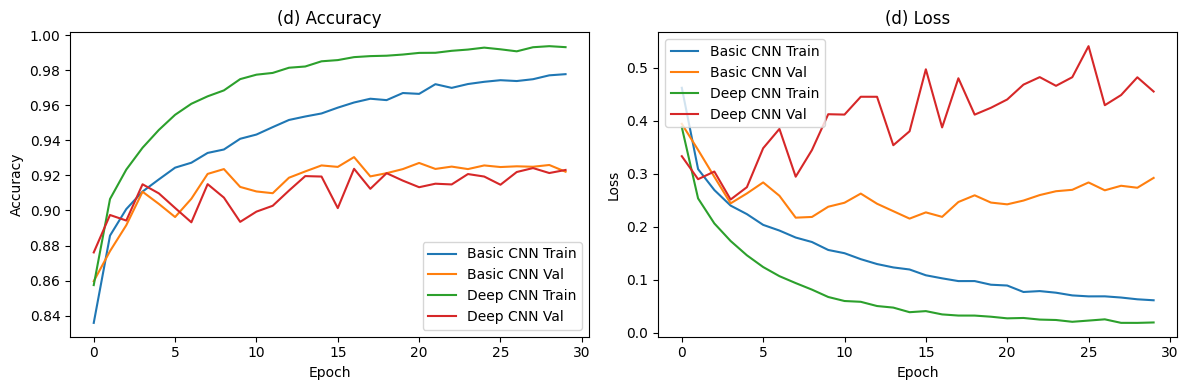


(e) Overfitting gap


,Model,Mean Train-Val Gap (last 5 epochs)
0,Basic CNN (opt),0.0509
1,Deep CNN (opt),0.0714


In [ ]:
# 11) (d) Convergence behavior
def plot_curves(best_a, best_b, label_a="Basic CNN", label_b="Deep CNN"):
    """Plots the training and validation accuracy and loss curves."""
    fig, ax = plt.subplots(1, 2, figsize=(12, 4)) # Create subplots

    # Plot accuracy curves
    ax[0].plot(best_a["hist"].history["accuracy"],     label=f"{label_a} Train")
    ax[0].plot(best_a["hist"].history["val_accuracy"], label=f"{label_a} Val")
    ax[0].plot(best_b["hist"].history["accuracy"],     label=f"{label_b} Train")
    ax[0].plot(best_b["hist"].history["val_accuracy"], label=f"{label_b} Val")
    ax[0].set_title("(d) Accuracy"); ax[0].set_xlabel("Epoch"); ax[0].set_ylabel("Accuracy"); ax[0].legend()

    # Plot loss curves
    ax[1].plot(best_a["hist"].history["loss"],     label=f"{label_a} Train")
    ax[1].plot(best_a["hist"].history["val_loss"], label=f"{label_a} Val")
    ax[1].plot(best_b["hist"].history["loss"],     label=f"{label_b} Train")
    ax[1].plot(best_b["hist"].history["val_loss"], label=f"{label_b} Val")
    ax[1].set_title("(d) Loss"); ax[1].set_xlabel("Epoch"); ax[1].set_ylabel("Loss"); ax[1].legend()

    plt.tight_layout(); plt.show() # Adjust layout and show plot

print("\n(d) Convergence curves")
plot_curves(basic_best, deep_best) # Plot convergence curves for best models

# 12) (e) Overfitting tendencies (gap)
def last5_gap(hist):
    """Calculates the mean difference between training and validation accuracy over the last 5 epochs."""
    a = np.array(hist.history["accuracy"][-5:]) # Last 5 training accuracies
    v = np.array(hist.history["val_accuracy"][-5:]) # Last 5 validation accuracies
    return float(np.mean(a - v)) # Mean of the difference

# Create a DataFrame to display overfitting gap
gap_df = pd.DataFrame([
    {"Model":"Basic CNN (opt)", "Mean Train-Val Gap (last 5 epochs)": round(last5_gap(basic_best["hist"]), 4)},
    {"Model":"Deep CNN (opt)",  "Mean Train-Val Gap (last 5 epochs)": round(last5_gap(deep_best["hist"]), 4)},
])
print("\n(e) Overfitting gap")
display(gap_df) # Display the overfitting gap table



(f) Confusion matrices


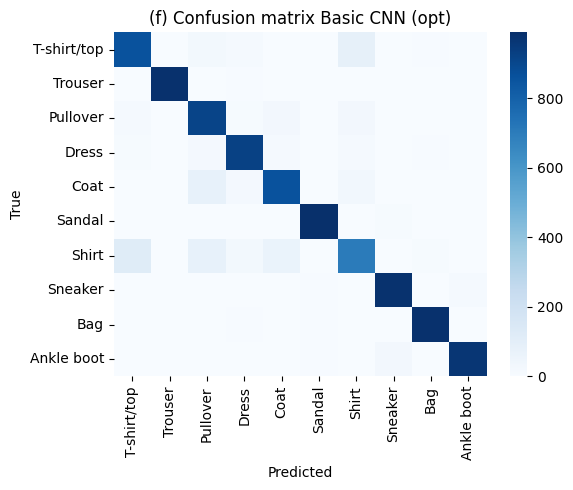

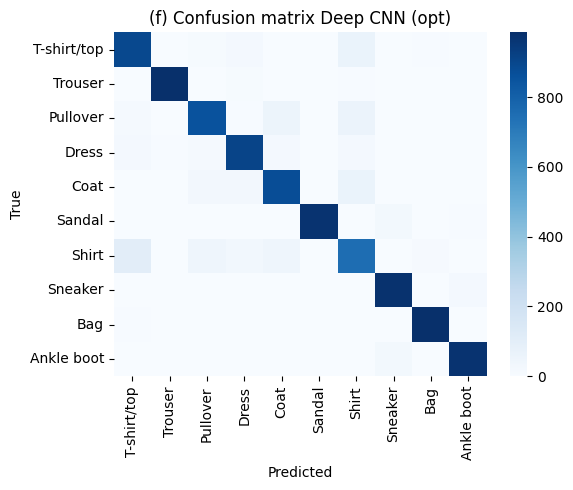


(g) Filter visualizations


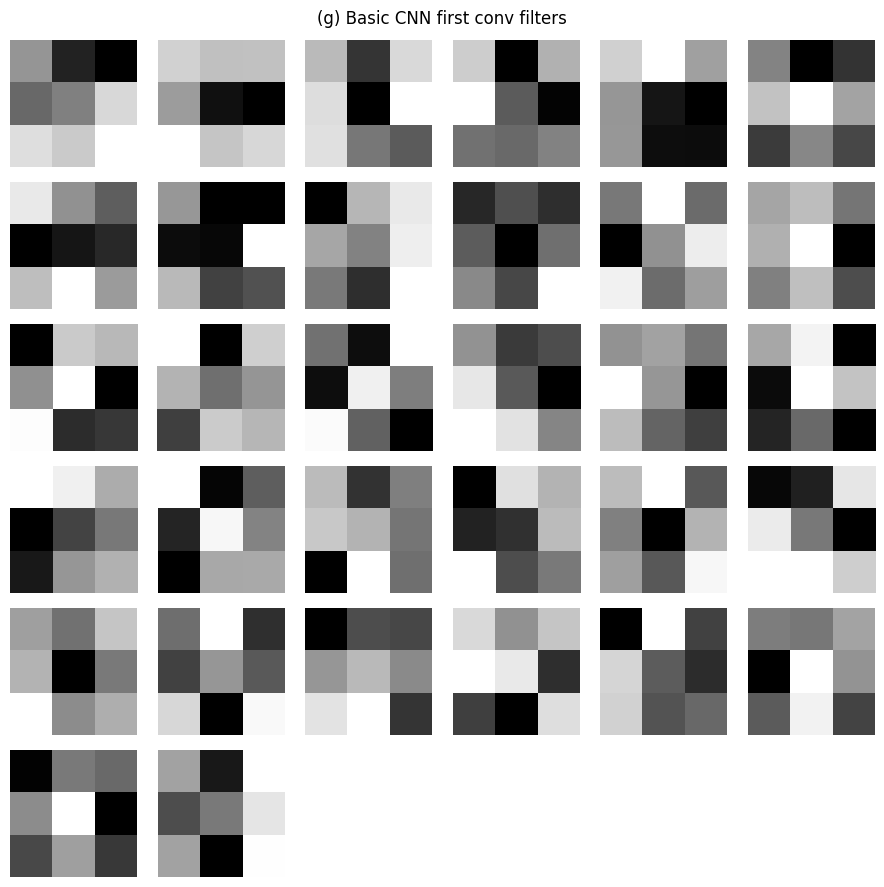

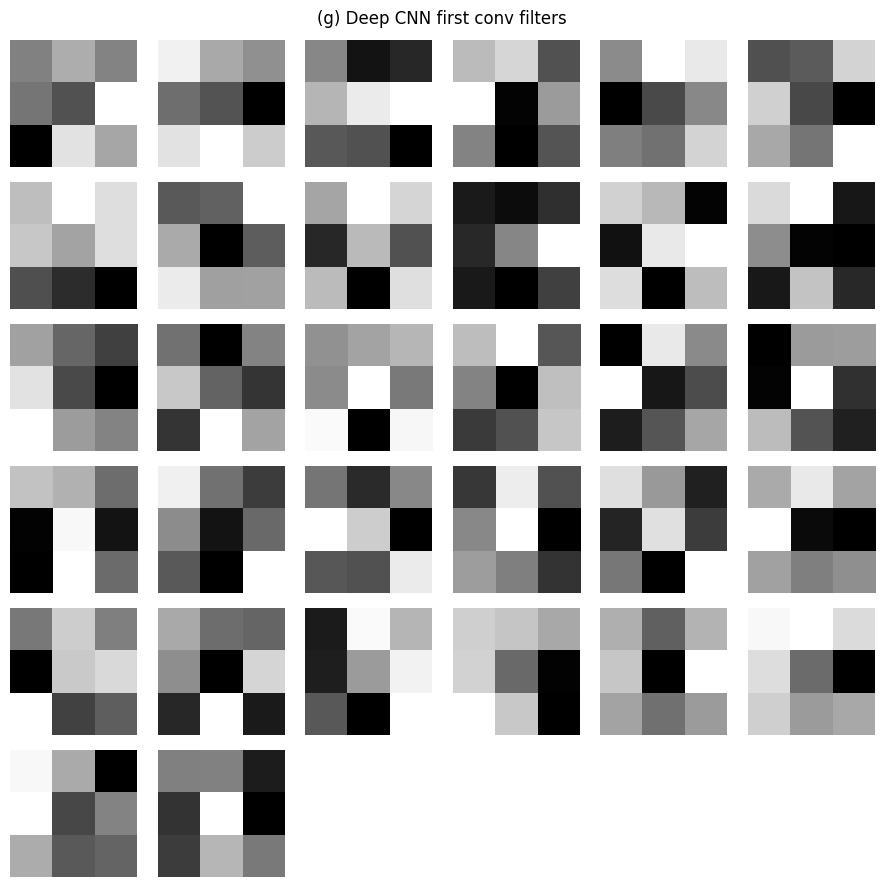

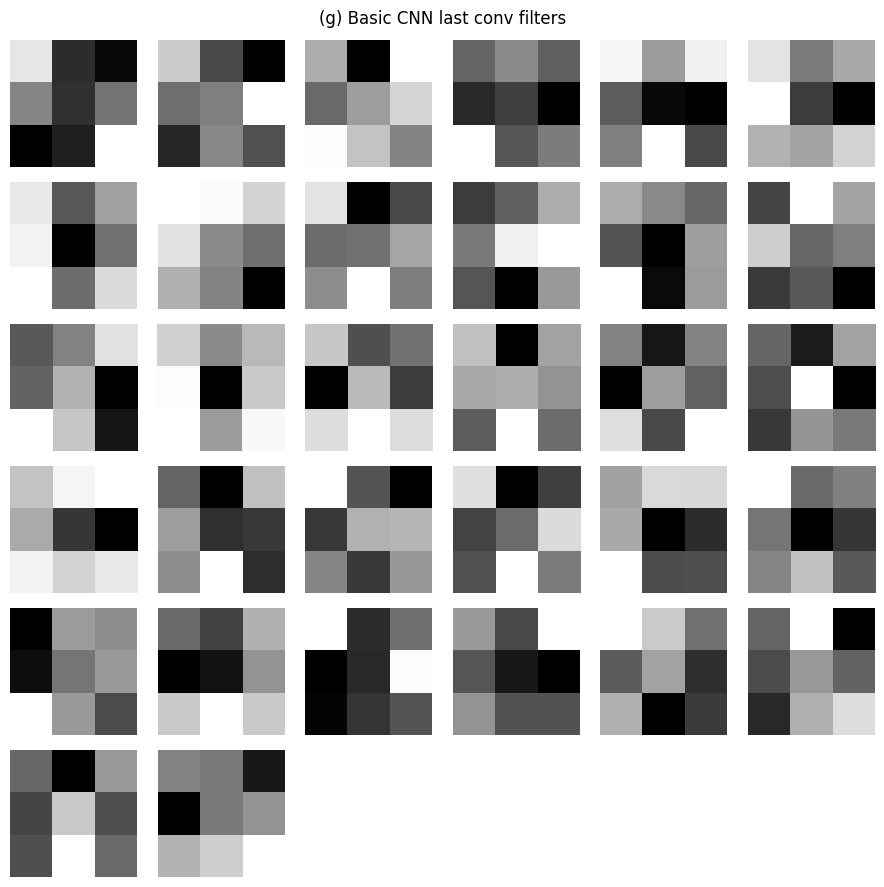

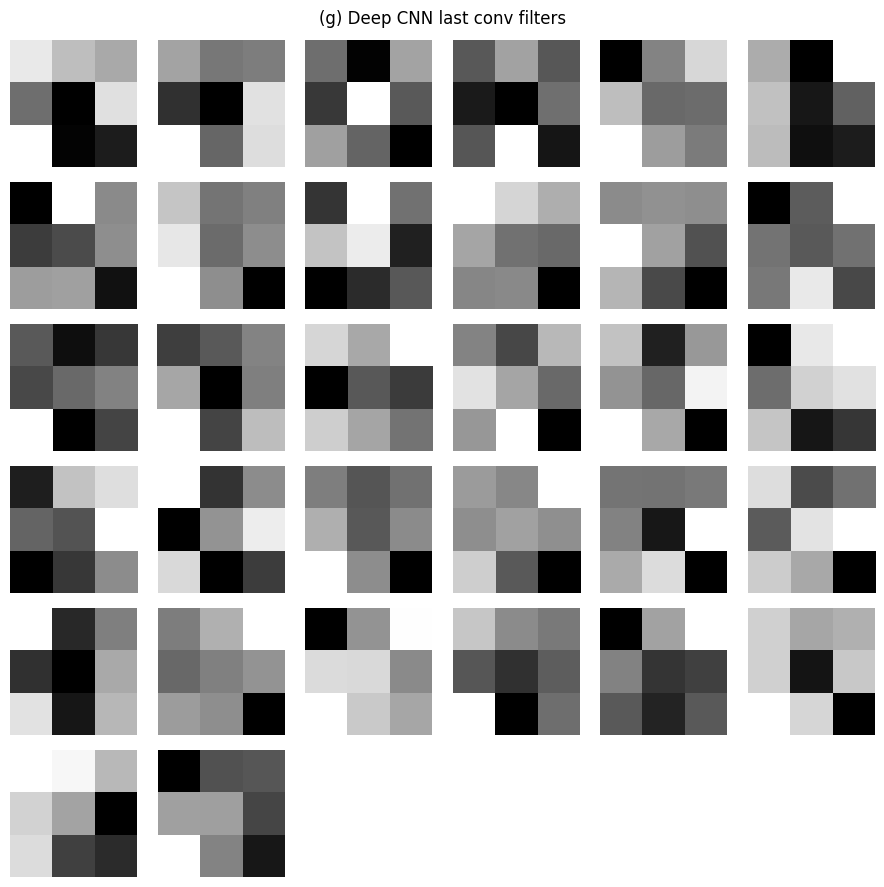

In [ ]:
# 13) (f) Confusion matrices (class names)
CLASS_NAMES = ["T-shirt/top","Trouser","Pullover","Dress","Coat",
               "Sandal","Shirt","Sneaker","Bag","Ankle boot"] # Class names for Fashion MNIST

def plot_confusion_named(model, ds, y_true_oh, title):
    """Plots a confusion matrix with class names."""
    y_true = np.argmax(y_true_oh, axis=1) # True labels
    y_pred = np.argmax(model.predict(ds, verbose=0), axis=1) # Predicted labels
    cm = confusion_matrix(y_true, y_pred, labels=list(range(10))) # Compute confusion matrix
    plt.figure(figsize=(6,5)) # Set figure size
    sns.heatmap(cm, annot=False, cmap="Blues", fmt="d", # Plot heatmap
                xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES) # Use class names as labels
    plt.title(f"(f) Confusion matrix {title}") # Set title
    plt.xlabel("Predicted"); plt.ylabel("True") # Set axis labels
    plt.tight_layout(); plt.show() # Adjust layout and show plot
    return cm

print("\n(f) Confusion matrices")
cm_basic = plot_confusion_named(basic_best["model"], test_ds, y_test_oh, "Basic CNN (opt)") # Plot confusion matrix for basic CNN
cm_deep  = plot_confusion_named(deep_best["model"],  test_ds, y_test_oh, "Deep CNN (opt)") # Plot confusion matrix for deep CNN

# 14) (g) Learned filter visualizations (early + late)
def get_conv_layers(model):
    """Returns a list of convolutional layers in the model."""
    return [l for l in model.layers if isinstance(l, layers.Conv2D)]

def show_filters_grid(weights, title, max_filters=32):
    """Visualizes learned filters from a convolutional layer."""
    w = weights # Get weights
    out_c = min(w.shape[-1], max_filters) # Number of filters to display
    cols = int(math.ceil(math.sqrt(out_c))); rows = int(math.ceil(out_c / cols)) # Determine grid size
    plt.figure(figsize=(cols*1.5, rows*1.5)) # Set figure size
    for i in range(out_c): # Iterate through filters
        f = w[..., i] # Get filter weights
        if f.shape[-1] > 1: f = np.mean(f, axis=-1) # Average across input channels if more than one
        f_min, f_max = f.min(), f.max() # Get min and max values for normalization
        f = (f - f_min) / (f_max - f_min + 1e-8) # Normalize filter weights to [0, 1]
        plt.subplot(rows, cols, i+1); plt.imshow(f, cmap="gray"); plt.axis("off") # Plot filter
    plt.suptitle(title); plt.tight_layout(); plt.show() # Set super title, adjust layout, and show plot

print("\n(g) Filter visualizations")
basic_convs = get_conv_layers(basic_best["model"]) # Get convolutional layers from basic CNN
deep_convs  = get_conv_layers(deep_best["model"]) # Get convolutional layers from deep CNN

# Early filters
show_filters_grid(basic_convs[0].get_weights()[0], "(g) Basic CNN first conv filters") # Visualize filters of the first convolutional layer
show_filters_grid(deep_convs[0].get_weights()[0],  "(g) Deep CNN first conv filters") # Visualize filters of the first convolutional layer

# Late filters
if len(basic_convs) > 1: # Check if basic CNN has more than one convolutional layer
    show_filters_grid(basic_convs[-1].get_weights()[0], "(g) Basic CNN last conv filters") # Visualize filters of the last convolutional layer
show_filters_grid(deep_convs[-1].get_weights()[0],  "(g) Deep CNN last conv filters") # Visualize filters of the last convolutional layer